[@LorenaABarba](https://twitter.com/LorenaABarba)

Step 3: Diffusion Equation in 1-D
-----
***

The one-dimensional diffusion equation is:

$$\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}$$

The first thing you should notice is that —unlike the previous two simple equations we have studied— this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing $\frac{\partial ^2 u}{\partial x^2}$

$u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\bigg|_i + O(\Delta x^4)$

Then rearrange to solve for $\frac{\partial ^2 u}{\partial x^2}\bigg|_i$ and the result is:

$$\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + O(\Delta x^2)$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

from sklearn.linear_model import Lasso as skLasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import pysindy as ps
from PDE_FIND import *
%matplotlib widget

In [2]:
def simulate(u0, t):
    U = np.ones((len(u0), len(t))) # Create an array to stor all timesteps
    for tn, t in enumerate(t):
        un = u.copy() # copy the existing values of u into un
        for i in range(1, nx-1):
            u[i] = un[i] + k * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
        U[:,tn] = u
    return U

#Alternative impelmentation so odeint may be used

def odefunc(u, t):
    dudt = np.zeros(u.shape)
    
    nx = u.shape[0]
    
    dudt[0] = 0 # insulated (Neumann) boundary condition
    dudt[-1] = 0
    #u[0] = 100 # Fixed temerature (Dirichlet 
    #u[1] = 200
    for i in range(1, nx-1):
        dudt[i] = k * (u[i + 1] - 2*u[i] + u[i - 1]) / dx**2

    return dudt

In [3]:
L=1
nx = 587
dx = L / (nx - 1)
tf = 0.1
k = 0.3   #the value of viscosity/thermal conductivity
#sigma = .2 #sigma is a parameter, we'll learn more about it later
sigma = .5 #sigma is a parameter, we'll learn more about it later

dt = sigma * dx**2 / k #dt is defined using sigma ... more later!

t = np.arange(0, tf, dt)
nt = len(t)    #the number of timesteps we want to calculate

print(f"nt = {nt}")

u = 25 * np.ones(nx)      #a numpy array with nx elements all equal to 1.
u[int(L*0.35 / dx):int(L*0.65 / dx + 1)] = 100

u0 = u  

nt = 20604


In [4]:
U1 = odeint(odefunc, u0, t) # Run the simulation

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
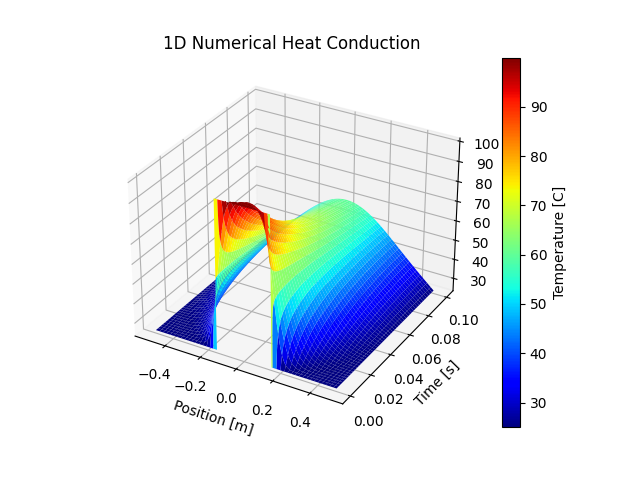

In [13]:
#plot the data
x = np.linspace(-L/2, L/2, nx)

X, T = np.meshgrid(x, t)
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d", title="1D Numerical Heat Conduction",
                                 xlabel="Position [m]", ylabel="Time [s]", zlabel="Temperature [C]")

#surf = ax.plot_surface(X, T, U1_reduced, cmap="jet")
surf = ax.plot_surface(X, T, U1, cmap="jet")
fig.colorbar(surf, label="Temperature [C]")

In [6]:
# Setup feature libraries for PySINDy
poly_lib = ps.PolynomialLibrary() #degree=2
fourier_lib = ps.FourierLibrary() #n_frequencies=3

custom_func = [
    lambda x : np.exp(x),
]
custom_func_names = [
    lambda x : f"exp({x})",
]

# PySINDy

In [7]:
%%capture --no-stdout
# Hide annoying warnings

model = ps.SINDy(t_default=t[1]-t[0])

# Setup parameters for grid search CV
param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "optimizer__alpha": [0.01, 0.05, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary(), 
                        ps.CustomLibrary(library_functions=custom_func, function_names=custom_func_names)+poly_lib],
    "differentiation_method__order": [1, 2]
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(u0)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'differentiation_method__order': 1, 'feature_library': <pysindy.feature_library.fourier_library.FourierLibrary object at 0x7fe5d772b460>, 'optimizer__alpha': 0.01, 'optimizer__threshold': 0.001}
x0' = 308032.309 sin(1 x0) + 79062.243 cos(1 x0)


## Using PDE-FIND

### Construct feature library ($\Theta (U)$) and compute $U_t$

Use `build_linear_system` function.

D = highest derivative to appear in $\Theta$  
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

Create smaller systems for U, since the number of candidate functions in $\Theta$ is given by $n_{spatial measurements}\cdot n_{time points} \times P \cdot (D+2)$
 

In [8]:
U1_red = U1[0:-1:50, :]
print(f"U1_red.shape = {U1_red.shape}")

U1_red.shape = (413, 587)


In [9]:
Ut, R, rhs_des = build_linear_system(U1_red, dt, dx, D=2, P=2, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}']

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [10]:
tscv = TimeSeriesSplit(n_splits=5)
        
for train_index, test_index in tscv.split(U1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = U1[train_index], U1[test_index]

In [11]:
# Solve with STRidge

lams = [1e-2, 0.1, 2.5e-1, 0.5]
d_tols =  [1e-2, 1e-1, 2.5e-1, 0.5]

for i,d in enumerate(d_tols):
    for j,l in enumerate(lams):
        w = TrainSTRidge(R, Ut, lam=l, d_tol=d/dx)
        print(f"PDE derived using STRidge for lam = {l} and d_tol = {d}")
        print_pde(w, rhs_des)
        print("\n-------------------------------------------------")

PDE derived using STRidge for lam = 0.01 and d_tol = 0.01
u_t = (7.319333 +0.000000i)
    + (-0.123251 +0.000000i)u
    + (-0.000656 +0.000000i)u^2
    + (0.175429 +0.000000i)u_{x}
    + (-0.012053 +0.000000i)uu_{x}
    + (0.000105 +0.000000i)u^2u_{x}
    + (0.000140 +0.000000i)u_{xx}
    + (-0.000012 +0.000000i)uu_{xx}
    + (0.000000 +0.000000i)u^2u_{xx}
   

-------------------------------------------------
PDE derived using STRidge for lam = 0.1 and d_tol = 0.01
u_t = (3.826165 +0.000000i)
    + (-0.001301 +0.000000i)u^2
    + (-0.060125 +0.000000i)u_{x}
    + (-0.001982 +0.000000i)uu_{x}
    + (0.000025 +0.000000i)u^2u_{x}
    + (-0.000175 +0.000000i)u_{xx}
    + (0.000002 +0.000000i)uu_{xx}
   

-------------------------------------------------
PDE derived using STRidge for lam = 0.25 and d_tol = 0.01
u_t = (3.398919 +0.000000i)
    + (-0.001040 +0.000000i)u^2
    + (-0.129685 +0.000000i)u_{x}
    + (0.001164 +0.000000i)uu_{x}
    + (-0.000214 +0.000000i)u_{xx}
    + (0.000003 +0

$T(0, t)= 100$  
$T(L, t) = 200$

$u0(x, 0)=150$  

$\frac{\partial^{2} u}{\partial x^{2}}=\frac{u(x+h)-2u(x)+u(x-h)}{h^{2}}$

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

tf = 0.5
dt = 0.01

nx = 587  # number of points to discretize
L = 1.0
x = np.linspace(0, L, nx) # position along the rod
dx = L / (nx - 1)

k = 0.02

u0 = 150*np.ones(x.shape)

u0[0] = 100 # BC1
u0[-1] = 200 # BC2

t = np.arange(0, tf, dt)

T = odeint(odefunc, u0, t)

for i in range(0, len(t), 5):
    plt.plot(x, T[i], label='t={0:1.2f}'.format(t[i]))

# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('X position')
plt.ylabel('Temperature')

# adjust figure edges so the legend is in the figure
plt.subplots_adjust(top=0.89, right=0.77)

X, T_g = np.meshgrid(x, t)
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d", title="Surface plot of data",
                                 xlabel="Position [m]", ylabel="Time [s]", zlabel="Temperature [C]")

surf = ax.plot_surface(x, T_g, T, cmap="jet")
fig.colorbar(surf, label="Temperature [C]")